In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hnilll","key":"bfc4ed724e586ceabd85f74999304c47"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 443M/450M [00:04<00:00, 115MB/s]
100% 450M/450M [00:04<00:00, 109MB/s]


In [4]:
from zipfile import  ZipFile
file_name = "flowers-recognition.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
##Import Libraries
import warnings
warnings.filterwarnings('ignore')

import cv2       # open CV
import os

# Data manipulation & visulation
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense
from keras.layers import Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import to_categorical    # one hot encoding
from keras.models import Sequential
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau


import random as rn
from tqdm import tqdm

In [6]:
print(os.listdir('/content/flowers/flowers'))

['daisy', 'sunflower', 'tulip', 'rose', 'dandelion']


In [7]:
Daisy_flower_dir = '/content/flowers/flowers/daisy'
Sunflower_flower_dir = '/content/flowers/flowers/sunflower'
# Tulip_flower_dir = '/content/flowers/flowers/tulip'
# Dandelion_flower_dir = '/content/flowers/flowers/dandelion'
# Rose_flower_dir = '/content/flowers/flowers/rose'

In [8]:
images = []
labels = []
img_size = 150

def image_data(flower_name, DIR):
    for i in tqdm(os.listdir(DIR)):
        try:
            
            path = os.path.join(DIR,i)
            img = cv2.imread(path)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
            images.append(np.array(img))
            labels.append(str(flower_name))
            
        except:
            print(path)

In [9]:
image_data('Daisy', Daisy_flower_dir)
len(images)

100%|██████████| 769/769 [00:02<00:00, 375.13it/s]


769

In [10]:
image_data('Sunflower', Sunflower_flower_dir)
len(images)

100%|██████████| 734/734 [00:02<00:00, 323.54it/s]


1503

In [ ]:
# image_data('Tulip', Tulip_flower_dir)
# len(images)

100%|██████████| 984/984 [00:02<00:00, 361.64it/s]


2487

In [ ]:
# image_data('Dandelion', Dandelion_flower_dir)
# len(images)

 38%|███▊      | 401/1055 [00:01<00:01, 365.68it/s]

/content/flowers/flowers/dandelion/flickr.py


 86%|████████▌ | 906/1055 [00:02<00:00, 362.14it/s]

/content/flowers/flowers/dandelion/run_me.py


100%|██████████| 1055/1055 [00:02<00:00, 363.96it/s]

/content/flowers/flowers/dandelion/flickr.pyc


3539

In [ ]:
# image_data('Rose', Rose_flower_dir)
# len(images)

100%|██████████| 784/784 [00:01<00:00, 431.11it/s]


4323

In [11]:
data = np.array(images)
labels = np.array(labels)
print('Input(Feature) Data shape :', data.shape)
print('Output(Labels) Data shape :', labels.shape)

Input(Feature) Data shape : (1503, 150, 150, 3)
Output(Labels) Data shape : (1503,)


Visualizing random Images

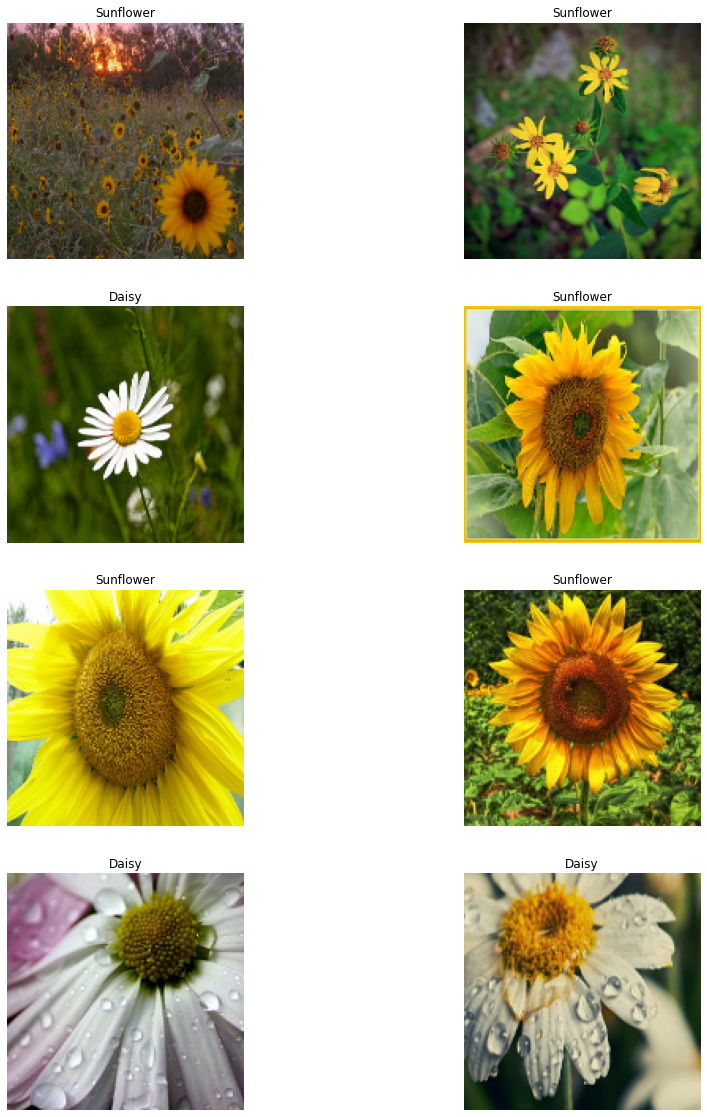

In [12]:
fig, ax = plt.subplots(4, 2, figsize = (15, 20))
for i in range(4):
    for j in range(2):
        l = rn.randint(0, data.shape[0])
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(labels[l])
        ax[i,j].axis('off')
        

Count plot for each class

Text(0.5, 0, 'Class Number')

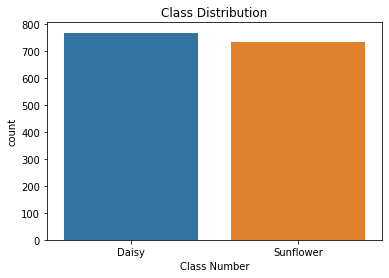

In [13]:
sns.countplot(labels)
plt.title("Class Distribution")
plt.xlabel("Class Number")

One Hot Encoding of labels

In [14]:
le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y, 2)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
# Normalize the input data in range [0 1]
X = data/255

Spliting data in to training and test set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :" ,X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (1202, 150, 150, 3)
y_train shape : (1202, 2)
X_test shape : (301, 150, 150, 3)
y_test shape : (301, 2)


Set Random Seed

In [ ]:
np.random.seed(40)
rn.seed(40)

Preparing Base model

In [17]:
Base_model = VGG16(include_top= False, weights='imagenet',input_shape=(150,150,3), pooling='max')
Base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Add own fully connected Layers

In [18]:
model = Sequential()

model.add(Base_model)
model.add(Dense(256,activation='relu'))
# adding prediction(softmax) layer
model.add(Dense(2,activation="softmax"))

In [19]:
# freeze layers(Base Model)
Base_model.trainable = False

Annealer

In [20]:
# Set a learning rate annealer

red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

Data augmentation to prevent Overfitting

In [21]:
datagen = ImageDataGenerator(featurewise_center= False,
                              samplewise_center= False,
                              featurewise_std_normalization= False,
                              samplewise_std_normalization=False,
                              rotation_range= 10,        # 0- 180
                              zca_whitening=False,
                              zoom_range=0.1,            # Randomly zoom image
                              width_shift_range=0.2,     # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.2,    # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True,      # randomly flip images
                              vertical_flip=False)       # randomly flip images
                             
datagen.fit(X_train)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


Compile and train the model

In [23]:
model.compile(optimizer=Adam(lr = 1e-4), loss= 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
batch_size=64
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 20, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/20
18/18 [==============================] - 307s 17s/step - loss: 0.8044 - accuracy: 0.4871 - val_loss: 0.6711 - val_accuracy: 0.6146
Epoch 2/20
18/18 [==============================] - 307s 17s/step - loss: 0.6416 - accuracy: 0.6432 - val_loss: 0.5530 - val_accuracy: 0.7176
Epoch 3/20
18/18 [==============================] - 306s 17s/step - loss: 0.5353 - accuracy: 0.7373 - val_loss: 0.4967 - val_accuracy: 0.7575
Epoch 4/20
18/18 [==============================] - 306s 17s/step - loss: 0.4631 - accuracy: 0.8145 - val_loss: 0.4790 - val_accuracy: 0.7674
Epoch 5/20
18/18 [==============================] - 304s 17s/step - loss: 0.4489 - accuracy: 0.7990 - val_loss: 0.4160 - val_accuracy: 0.8306
Epoch 6/20
18/18 [==============================] - 304s 17s/step - loss: 0.4124 - accuracy: 0.8325 - val_loss: 0.3878 - val_accuracy: 0.8638
Epoch 7/20
18/18 [==============================] - 302s 17s/step - loss: 0.3877 - accuracy: 0.8380 - val_loss: 0.3660 - val_accuracy: 0.8738
Epoch 

Model Accuracy

Text(0, 0.5, 'Accuracy')

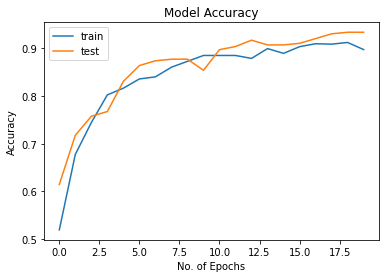

In [25]:
plt.plot(History.epoch, History.history['accuracy'])
plt.plot(History.epoch, History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['train', 'test'])
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')

Model Loss

Text(0, 0.5, 'Loss')

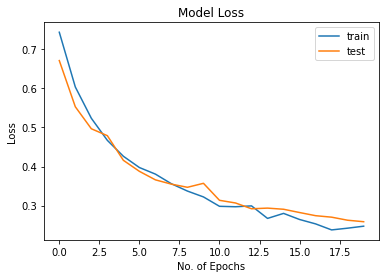

In [26]:
plt.plot(History.epoch, History.history['loss'])
plt.plot(History.epoch, History.history['val_loss'])
plt.title('Model Loss')
plt.legend(['train', 'test'])
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')